In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from cnnlstmnetwork import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CNNLSTMDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

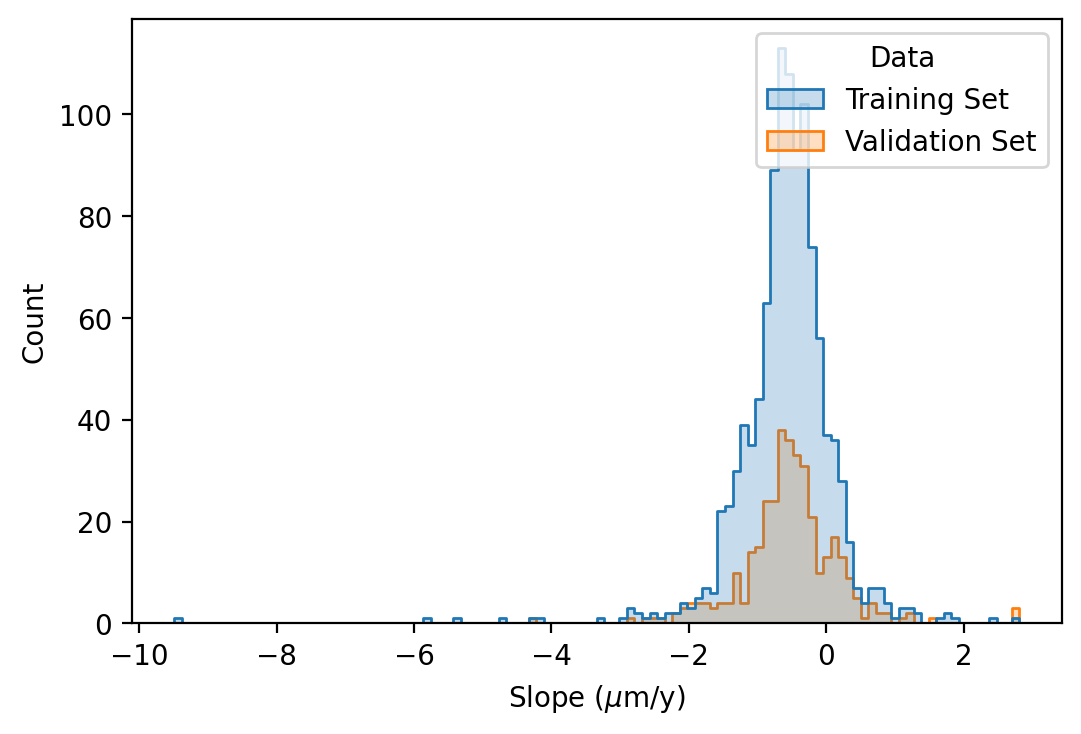

In [11]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [12]:
print(len(true_scores), len(valtrue_scores))

1098 366


In [23]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [24]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 18/18 [00:03<00:00,  5.27it/s, batch_loss=0.288, running_loss=9.95]


Train Loss: 9.9548 | Valid Loss: inf ===========> 3.2456 | Test Loss: 2.8619 | Saving model...


Epoch [2/200]: 100%|██████████| 18/18 [00:03<00:00,  5.40it/s, batch_loss=0.235, running_loss=9.25]


Train Loss: 9.2480 | Valid Loss: 3.2456 ===========> 3.1584 | Test Loss: 2.9144 | Saving model...


Epoch [3/200]: 100%|██████████| 18/18 [00:03<00:00,  5.39it/s, batch_loss=0.166, running_loss=9.18]


Train Loss: 9.1795 | Valid Loss: 3.2421


Epoch [4/200]: 100%|██████████| 18/18 [00:03<00:00,  5.26it/s, batch_loss=0.257, running_loss=9.32]


Train Loss: 9.3231 | Valid Loss: 3.1647


Epoch [5/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=1.44, running_loss=10.2]


Train Loss: 10.2210 | Valid Loss: 3.1946


Epoch [6/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.212, running_loss=9.23]


Train Loss: 9.2295 | Valid Loss: 3.1584 ===========> 3.1312 | Test Loss: 2.9112 | Saving model...


Epoch [7/200]: 100%|██████████| 18/18 [00:03<00:00,  5.27it/s, batch_loss=0.193, running_loss=9.15]


Train Loss: 9.1519 | Valid Loss: 3.2999


Epoch [8/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.217, running_loss=9.19]


Train Loss: 9.1873 | Valid Loss: 3.2749


Epoch [9/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=7.98, running_loss=15.7]


Train Loss: 15.7365 | Valid Loss: 4.5105


Epoch [10/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.276, running_loss=9.53]


Train Loss: 9.5299 | Valid Loss: 3.1810


Epoch [11/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.341, running_loss=9.21]


Train Loss: 9.2069 | Valid Loss: 3.1620


Epoch [12/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=3.43, running_loss=11.8]


Train Loss: 11.8465 | Valid Loss: 3.7718


Epoch [13/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.133, running_loss=9.13]


Train Loss: 9.1302 | Valid Loss: 3.1955


Epoch [14/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.474, running_loss=9.21]


Train Loss: 9.2102 | Valid Loss: 3.3493


Epoch [15/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.554, running_loss=9.16]


Train Loss: 9.1605 | Valid Loss: 3.2220


Epoch [16/200]: 100%|██████████| 18/18 [00:03<00:00,  5.28it/s, batch_loss=0.317, running_loss=8.83]


Train Loss: 8.8290 | Valid Loss: 3.1691


Epoch [17/200]: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s, batch_loss=0.607, running_loss=8.98]


Train Loss: 8.9787 | Valid Loss: 3.1312 ===========> 3.1214 | Test Loss: 2.8748 | Saving model...


Epoch [18/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.143, running_loss=8.73]


Train Loss: 8.7311 | Valid Loss: 3.5518


Epoch [19/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.179, running_loss=8.71]


Train Loss: 8.7094 | Valid Loss: 3.3398


Epoch [20/200]: 100%|██████████| 18/18 [00:03<00:00,  5.29it/s, batch_loss=0.646, running_loss=8.89]


Train Loss: 8.8879 | Valid Loss: 3.2309


Epoch [21/200]: 100%|██████████| 18/18 [00:03<00:00,  5.28it/s, batch_loss=0.549, running_loss=9.08]


Train Loss: 9.0775 | Valid Loss: 7.6394


Epoch [22/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.274, running_loss=8.88]


Train Loss: 8.8816 | Valid Loss: 3.1457


Epoch [23/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.76, running_loss=8.66]


Train Loss: 8.6602 | Valid Loss: 3.4351


Epoch [24/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.583, running_loss=8.44]


Train Loss: 8.4353 | Valid Loss: 3.3288


Epoch [25/200]: 100%|██████████| 18/18 [00:03<00:00,  5.28it/s, batch_loss=0.315, running_loss=8.17]


Train Loss: 8.1672 | Valid Loss: 3.6010


Epoch [26/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.17, running_loss=8.2]


Train Loss: 8.2041 | Valid Loss: 3.1214 ===========> 3.0388 | Test Loss: 2.9719 | Saving model...


Epoch [27/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.244, running_loss=7.76]


Train Loss: 7.7579 | Valid Loss: 3.1820


Epoch [28/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.194, running_loss=7.42]


Train Loss: 7.4202 | Valid Loss: 4.4989


Epoch [29/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.412, running_loss=9.38]


Train Loss: 9.3761 | Valid Loss: 3.1118


Epoch [30/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.128, running_loss=8.53]


Train Loss: 8.5346 | Valid Loss: 4.3175


Epoch [31/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.152, running_loss=7.2]


Train Loss: 7.2036 | Valid Loss: 3.7481


Epoch [32/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.153, running_loss=8.41]


Train Loss: 8.4124 | Valid Loss: 3.1492


Epoch [33/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.441, running_loss=9.39]


Train Loss: 9.3932 | Valid Loss: 3.1596


Epoch [34/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.302, running_loss=9.17]


Train Loss: 9.1705 | Valid Loss: 3.2900


Epoch [35/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.289, running_loss=9.19]


Train Loss: 9.1902 | Valid Loss: 3.1381


Epoch [36/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.711, running_loss=9.37]


Train Loss: 9.3682 | Valid Loss: 3.1612


Epoch [37/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.458, running_loss=8.13]


Train Loss: 8.1298 | Valid Loss: 25.4086


Epoch [38/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.675, running_loss=11.5]


Train Loss: 11.4625 | Valid Loss: 3.0855


Epoch [39/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.184, running_loss=9.18]


Train Loss: 9.1799 | Valid Loss: 3.1160


Epoch [40/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.493, running_loss=9.39]


Train Loss: 9.3949 | Valid Loss: 3.2147


Epoch [41/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.937, running_loss=9.79]


Train Loss: 9.7938 | Valid Loss: 3.1369


Epoch [42/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.147, running_loss=9.07]


Train Loss: 9.0732 | Valid Loss: 3.2816


Epoch [43/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.479, running_loss=9.31]


Train Loss: 9.3115 | Valid Loss: 3.2900


Epoch [44/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=1.79, running_loss=10.4]


Train Loss: 10.3586 | Valid Loss: 3.2443


Epoch [45/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.296, running_loss=9.04]


Train Loss: 9.0370 | Valid Loss: 3.5086


Epoch [46/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.4, running_loss=8.92]


Train Loss: 8.9204 | Valid Loss: 3.1768


Epoch [47/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.419, running_loss=8.73]


Train Loss: 8.7280 | Valid Loss: 3.1894


Epoch [48/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=1.35, running_loss=9.17]


Train Loss: 9.1671 | Valid Loss: 3.7473


Epoch [49/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.167, running_loss=8.53]


Train Loss: 8.5341 | Valid Loss: 3.3379


Epoch [50/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.243, running_loss=8.33]


Train Loss: 8.3339 | Valid Loss: 3.5000


Epoch [51/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.317, running_loss=8.27]


Train Loss: 8.2689 | Valid Loss: 3.2579


Epoch [52/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.383, running_loss=7.52]


Train Loss: 7.5169 | Valid Loss: 3.2947


Epoch [53/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.327, running_loss=7.57]


Train Loss: 7.5680 | Valid Loss: 3.5784


Epoch [54/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.122, running_loss=6.26]


Train Loss: 6.2618 | Valid Loss: 3.4590


Epoch [55/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.234, running_loss=7.06]


Train Loss: 7.0598 | Valid Loss: 3.3031


Epoch [56/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.28, running_loss=4.92]


Train Loss: 4.9227 | Valid Loss: 17.9878


Epoch [57/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.459, running_loss=13.5]


Train Loss: 13.5009 | Valid Loss: 3.2203


Epoch [58/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.315, running_loss=9.32]


Train Loss: 9.3196 | Valid Loss: 3.1289


Epoch [59/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.6, running_loss=9.56]


Train Loss: 9.5568 | Valid Loss: 3.2162


Epoch [60/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.392, running_loss=9.39]


Train Loss: 9.3941 | Valid Loss: 3.1321


Epoch [61/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.115, running_loss=9.15]


Train Loss: 9.1498 | Valid Loss: 3.0990


Epoch [62/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.21, running_loss=9.22]


Train Loss: 9.2197 | Valid Loss: 3.1558


Epoch [63/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.274, running_loss=9.29]


Train Loss: 9.2881 | Valid Loss: 3.2848


Epoch [64/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.853, running_loss=9.77]


Train Loss: 9.7696 | Valid Loss: 3.2059


Epoch [65/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.263, running_loss=9.29]


Train Loss: 9.2864 | Valid Loss: 3.0597


Epoch [66/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.137, running_loss=9.16]


Train Loss: 9.1573 | Valid Loss: 3.1979


Epoch [67/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.251, running_loss=9.28]


Train Loss: 9.2772 | Valid Loss: 3.2452


Epoch [68/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.195, running_loss=9.2]


Train Loss: 9.1956 | Valid Loss: 3.1445


Epoch [69/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=1.35, running_loss=10.2]


Train Loss: 10.1921 | Valid Loss: 3.2819


Epoch [70/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.165, running_loss=9.24]


Train Loss: 9.2424 | Valid Loss: 3.1784


Epoch [71/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.161, running_loss=9.19]


Train Loss: 9.1855 | Valid Loss: 3.0557


Epoch [72/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.291, running_loss=9.31]


Train Loss: 9.3132 | Valid Loss: 3.2567


Epoch [73/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.178, running_loss=9.2]


Train Loss: 9.1973 | Valid Loss: 3.1488


Epoch [74/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.389, running_loss=9.37]


Train Loss: 9.3740 | Valid Loss: 3.2286


Epoch [75/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.23, running_loss=9.22]


Train Loss: 9.2243 | Valid Loss: 3.1686


Epoch [76/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.127, running_loss=9.15]


Train Loss: 9.1526 | Valid Loss: 3.1389


Epoch [77/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=1.27, running_loss=10.1]


Train Loss: 10.1083 | Valid Loss: 3.3628


Epoch [78/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.338, running_loss=9.36]


Train Loss: 9.3564 | Valid Loss: 3.1835


Epoch [79/200]: 100%|██████████| 18/18 [00:03<00:00,  5.40it/s, batch_loss=0.477, running_loss=9.42]


Train Loss: 9.4192 | Valid Loss: 3.1653


Epoch [80/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.416, running_loss=9.35]


Train Loss: 9.3531 | Valid Loss: 3.1123


Epoch [81/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.249, running_loss=9.18]


Train Loss: 9.1794 | Valid Loss: 3.1107


Epoch [82/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.809, running_loss=9.64]


Train Loss: 9.6363 | Valid Loss: 3.1870


Epoch [83/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=1.08, running_loss=9.81]


Train Loss: 9.8084 | Valid Loss: 3.2864


Epoch [84/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.579, running_loss=9.36]


Train Loss: 9.3649 | Valid Loss: 3.1574


Epoch [85/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.162, running_loss=8.95]


Train Loss: 8.9472 | Valid Loss: 3.1968


Epoch [86/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.406, running_loss=9.04]


Train Loss: 9.0373 | Valid Loss: 3.1135


Epoch [87/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.109, running_loss=8.76]


Train Loss: 8.7615 | Valid Loss: 3.1541


Epoch [88/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.337, running_loss=8.66]


Train Loss: 8.6630 | Valid Loss: 3.9751


Epoch [89/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.257, running_loss=9]


Train Loss: 9.0017 | Valid Loss: 3.2449


Epoch [90/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=1.71, running_loss=9.67]


Train Loss: 9.6719 | Valid Loss: 4.0884


Epoch [91/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.26, running_loss=8.79]


Train Loss: 8.7896 | Valid Loss: 3.2895


Epoch [92/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.466, running_loss=8.52]


Train Loss: 8.5182 | Valid Loss: 5.4322


Epoch [93/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.314, running_loss=8.54]


Train Loss: 8.5442 | Valid Loss: 3.6793


Epoch [94/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.185, running_loss=8.27]


Train Loss: 8.2682 | Valid Loss: 3.5198


Epoch [95/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.465, running_loss=8.09]


Train Loss: 8.0871 | Valid Loss: 4.1441


Epoch [96/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.159, running_loss=7.78]


Train Loss: 7.7773 | Valid Loss: 3.4881


Epoch [97/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.161, running_loss=7.75]


Train Loss: 7.7533 | Valid Loss: 4.2521


Epoch [98/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.673, running_loss=7.29]


Train Loss: 7.2892 | Valid Loss: 5.8366


Epoch [99/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.149, running_loss=7.35]


Train Loss: 7.3492 | Valid Loss: 3.4162


Epoch [100/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.103, running_loss=7.47]


Train Loss: 7.4724 | Valid Loss: 3.9635


Epoch [101/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0489, running_loss=7.24]


Train Loss: 7.2392 | Valid Loss: 3.2010


Epoch [102/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.439, running_loss=6.51]


Train Loss: 6.5118 | Valid Loss: 5.2883


Epoch [103/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0734, running_loss=7.76]


Train Loss: 7.7621 | Valid Loss: 3.6173


Epoch [104/200]: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s, batch_loss=0.139, running_loss=6.57]


Train Loss: 6.5689 | Valid Loss: 3.5910


Epoch [105/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.781, running_loss=6.37]


Train Loss: 6.3706 | Valid Loss: 10.6829


Epoch [106/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.105, running_loss=6.71]


Train Loss: 6.7150 | Valid Loss: 4.1497


Epoch [107/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.904, running_loss=6.48]


Train Loss: 6.4761 | Valid Loss: 4.0278


Epoch [108/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.159, running_loss=6.18]


Train Loss: 6.1803 | Valid Loss: 3.7598


Epoch [109/200]: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s, batch_loss=0.434, running_loss=5.76]


Train Loss: 5.7600 | Valid Loss: 5.0450


Epoch [110/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.36, running_loss=5.87]


Train Loss: 5.8670 | Valid Loss: 6.8916


Epoch [111/200]: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s, batch_loss=0.398, running_loss=6.53]


Train Loss: 6.5296 | Valid Loss: 6.8091


Epoch [112/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.066, running_loss=5.9]


Train Loss: 5.8994 | Valid Loss: 4.7516


Epoch [113/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.138, running_loss=3.72]


Train Loss: 3.7195 | Valid Loss: 3.5713


Epoch [114/200]: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s, batch_loss=0.0505, running_loss=5.65]


Train Loss: 5.6464 | Valid Loss: 3.4854


Epoch [115/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.222, running_loss=5.67]


Train Loss: 5.6664 | Valid Loss: 4.7932


Epoch [116/200]: 100%|██████████| 18/18 [00:03<00:00,  5.31it/s, batch_loss=0.0857, running_loss=4.49]


Train Loss: 4.4859 | Valid Loss: 12.5341


Epoch [117/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.298, running_loss=4.72]


Train Loss: 4.7156 | Valid Loss: 4.3996


Epoch [118/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.102, running_loss=3.41]


Train Loss: 3.4092 | Valid Loss: 3.2773


Epoch [119/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.178, running_loss=4.44]


Train Loss: 4.4401 | Valid Loss: 3.7369


Epoch [120/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.13, running_loss=3.69]


Train Loss: 3.6903 | Valid Loss: 4.0513


Epoch [121/200]: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s, batch_loss=0.0503, running_loss=2.34]


Train Loss: 2.3435 | Valid Loss: 3.5545


Epoch [122/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0627, running_loss=1.92]


Train Loss: 1.9204 | Valid Loss: 3.5137


Epoch [123/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.152, running_loss=1.85]


Train Loss: 1.8499 | Valid Loss: 3.4646


Epoch [124/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0645, running_loss=1.71]


Train Loss: 1.7129 | Valid Loss: 3.5619


Epoch [125/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0357, running_loss=1.56]


Train Loss: 1.5609 | Valid Loss: 3.5771


Epoch [126/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0851, running_loss=1.66]


Train Loss: 1.6605 | Valid Loss: 3.6030


Epoch [127/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.11, running_loss=1.63]


Train Loss: 1.6319 | Valid Loss: 3.5232


Epoch [128/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.103, running_loss=1.64]


Train Loss: 1.6360 | Valid Loss: 3.5234


Epoch [129/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0625, running_loss=1.49]


Train Loss: 1.4935 | Valid Loss: 3.5939


Epoch [130/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.237, running_loss=1.67]


Train Loss: 1.6723 | Valid Loss: 3.4868


Epoch [131/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0313, running_loss=1.4]


Train Loss: 1.4037 | Valid Loss: 3.6367


Epoch [132/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0413, running_loss=1.49]


Train Loss: 1.4879 | Valid Loss: 3.6836


Epoch [133/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.0323, running_loss=1.34]


Train Loss: 1.3387 | Valid Loss: 3.5550


Epoch [134/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.123, running_loss=1.32]


Train Loss: 1.3238 | Valid Loss: 3.5628


Epoch [135/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0619, running_loss=1.36]


Train Loss: 1.3594 | Valid Loss: 3.4729


Epoch [136/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0636, running_loss=1.37]


Train Loss: 1.3721 | Valid Loss: 3.4984


Epoch [137/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.0963, running_loss=1.28]


Train Loss: 1.2841 | Valid Loss: 3.4299


Epoch [138/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0422, running_loss=1.29]


Train Loss: 1.2929 | Valid Loss: 3.4642


Epoch [139/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.163, running_loss=1.4]


Train Loss: 1.3957 | Valid Loss: 3.5730


Epoch [140/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0945, running_loss=1.21]


Train Loss: 1.2084 | Valid Loss: 3.4950


Epoch [141/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.106, running_loss=1.22]


Train Loss: 1.2226 | Valid Loss: 3.5161


Epoch [142/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.16, running_loss=1.25]


Train Loss: 1.2508 | Valid Loss: 3.5290


Epoch [143/200]: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s, batch_loss=0.0343, running_loss=1.17]


Train Loss: 1.1696 | Valid Loss: 3.5531


Epoch [144/200]: 100%|██████████| 18/18 [00:03<00:00,  5.29it/s, batch_loss=0.0744, running_loss=1.18]


Train Loss: 1.1839 | Valid Loss: 3.5801


Epoch [145/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0595, running_loss=1.14]


Train Loss: 1.1427 | Valid Loss: 3.5320


Epoch [146/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0478, running_loss=1.12]


Train Loss: 1.1191 | Valid Loss: 3.5425


Epoch [147/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0623, running_loss=1.05]


Train Loss: 1.0500 | Valid Loss: 3.5241


Epoch [148/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0262, running_loss=1.06]


Train Loss: 1.0615 | Valid Loss: 3.6175


Epoch [149/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.047, running_loss=1.06]


Train Loss: 1.0577 | Valid Loss: 3.5886


Epoch [150/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0589, running_loss=1.07]


Train Loss: 1.0674 | Valid Loss: 3.5356


Epoch [151/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.16, running_loss=1.18]


Train Loss: 1.1790 | Valid Loss: 3.6096


Epoch [152/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.06, running_loss=1.08]


Train Loss: 1.0751 | Valid Loss: 3.4959


Epoch [153/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.058, running_loss=1]


Train Loss: 1.0040 | Valid Loss: 3.5885


Epoch [154/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0748, running_loss=0.988]


Train Loss: 0.9877 | Valid Loss: 3.5257


Epoch [155/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0646, running_loss=0.959]


Train Loss: 0.9589 | Valid Loss: 3.6021


Epoch [156/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.109, running_loss=1.06]


Train Loss: 1.0607 | Valid Loss: 3.5192


Epoch [157/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0407, running_loss=0.883]


Train Loss: 0.8833 | Valid Loss: 3.5841


Epoch [158/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.032, running_loss=0.921]


Train Loss: 0.9205 | Valid Loss: 3.5244


Epoch [159/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0851, running_loss=0.952]


Train Loss: 0.9518 | Valid Loss: 3.6344


Epoch [160/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.0852, running_loss=0.944]


Train Loss: 0.9442 | Valid Loss: 3.5437


Epoch [161/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.111, running_loss=1.01]


Train Loss: 1.0082 | Valid Loss: 3.5657


Epoch [162/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0545, running_loss=0.847]


Train Loss: 0.8474 | Valid Loss: 3.5700


Epoch [163/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0296, running_loss=0.83]


Train Loss: 0.8305 | Valid Loss: 3.4888


Epoch [164/200]: 100%|██████████| 18/18 [00:03<00:00,  5.39it/s, batch_loss=0.0124, running_loss=0.884]


Train Loss: 0.8839 | Valid Loss: 3.5394


Epoch [165/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.126, running_loss=0.957]


Train Loss: 0.9571 | Valid Loss: 3.5513


Epoch [166/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0225, running_loss=0.833]


Train Loss: 0.8331 | Valid Loss: 3.7787


Epoch [167/200]: 100%|██████████| 18/18 [00:03<00:00,  5.28it/s, batch_loss=0.25, running_loss=1.05]


Train Loss: 1.0509 | Valid Loss: 3.5881


Epoch [168/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0836, running_loss=0.863]


Train Loss: 0.8631 | Valid Loss: 3.6720


Epoch [169/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0721, running_loss=0.875]


Train Loss: 0.8751 | Valid Loss: 3.5799


Epoch [170/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.0269, running_loss=0.805]


Train Loss: 0.8046 | Valid Loss: 3.5184


Epoch [171/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0521, running_loss=0.887]


Train Loss: 0.8873 | Valid Loss: 3.5710


Epoch [172/200]: 100%|██████████| 18/18 [00:03<00:00,  5.31it/s, batch_loss=0.0478, running_loss=0.838]


Train Loss: 0.8378 | Valid Loss: 3.5621


Epoch [173/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0545, running_loss=0.824]


Train Loss: 0.8244 | Valid Loss: 3.5643


Epoch [174/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0865, running_loss=0.802]


Train Loss: 0.8018 | Valid Loss: 3.5779


Epoch [175/200]: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s, batch_loss=0.113, running_loss=0.908]


Train Loss: 0.9080 | Valid Loss: 3.5958


Epoch [176/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0814, running_loss=0.853]


Train Loss: 0.8531 | Valid Loss: 3.5795


Epoch [177/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0427, running_loss=0.743]


Train Loss: 0.7426 | Valid Loss: 3.5697


Epoch [178/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.11, running_loss=0.799]


Train Loss: 0.7986 | Valid Loss: 3.4931


Epoch [179/200]: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s, batch_loss=0.0629, running_loss=0.839]


Train Loss: 0.8391 | Valid Loss: 3.5371


Epoch [180/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.0457, running_loss=0.79]


Train Loss: 0.7904 | Valid Loss: 3.5578


Epoch [181/200]: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s, batch_loss=0.0519, running_loss=0.78]


Train Loss: 0.7801 | Valid Loss: 3.5523


Epoch [182/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.0516, running_loss=0.788]


Train Loss: 0.7884 | Valid Loss: 3.5287


Epoch [183/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0258, running_loss=0.711]


Train Loss: 0.7110 | Valid Loss: 3.6011


Epoch [184/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.0855, running_loss=0.75]


Train Loss: 0.7497 | Valid Loss: 3.5480


Epoch [185/200]: 100%|██████████| 18/18 [00:03<00:00,  5.29it/s, batch_loss=0.0526, running_loss=0.717]


Train Loss: 0.7173 | Valid Loss: 3.6811


Epoch [186/200]: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s, batch_loss=0.0423, running_loss=0.71]


Train Loss: 0.7105 | Valid Loss: 3.5464


Epoch [187/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.031, running_loss=0.671]


Train Loss: 0.6714 | Valid Loss: 3.4681


Epoch [188/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.0325, running_loss=0.688]


Train Loss: 0.6879 | Valid Loss: 3.5911


Epoch [189/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.0378, running_loss=0.677]


Train Loss: 0.6769 | Valid Loss: 3.4702


Epoch [190/200]: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s, batch_loss=0.0513, running_loss=0.755]


Train Loss: 0.7547 | Valid Loss: 3.6147


Epoch [191/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.0227, running_loss=0.709]


Train Loss: 0.7092 | Valid Loss: 3.5230


Epoch [192/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.0319, running_loss=0.679]


Train Loss: 0.6790 | Valid Loss: 3.4464


Epoch [193/200]: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s, batch_loss=0.024, running_loss=0.657]


Train Loss: 0.6574 | Valid Loss: 3.5105


Epoch [194/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0711, running_loss=0.717]


Train Loss: 0.7174 | Valid Loss: 3.5064


Epoch [195/200]: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s, batch_loss=0.0567, running_loss=0.711]


Train Loss: 0.7108 | Valid Loss: 3.4514


Epoch [196/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.079, running_loss=0.741]


Train Loss: 0.7409 | Valid Loss: 3.5138


Epoch [197/200]: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s, batch_loss=0.033, running_loss=0.666]


Train Loss: 0.6661 | Valid Loss: 3.5442


Epoch [198/200]: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, batch_loss=0.12, running_loss=0.714]


Train Loss: 0.7144 | Valid Loss: 3.5167


Epoch [199/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0098, running_loss=0.674]


Train Loss: 0.6744 | Valid Loss: 3.4737


Epoch [200/200]: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s, batch_loss=0.0568, running_loss=0.705]


Train Loss: 0.7047 | Valid Loss: 3.4293


Train Loss: 8.2041 | Valid Loss: 3.0388 | Test Loss on Best Model: 2.9719


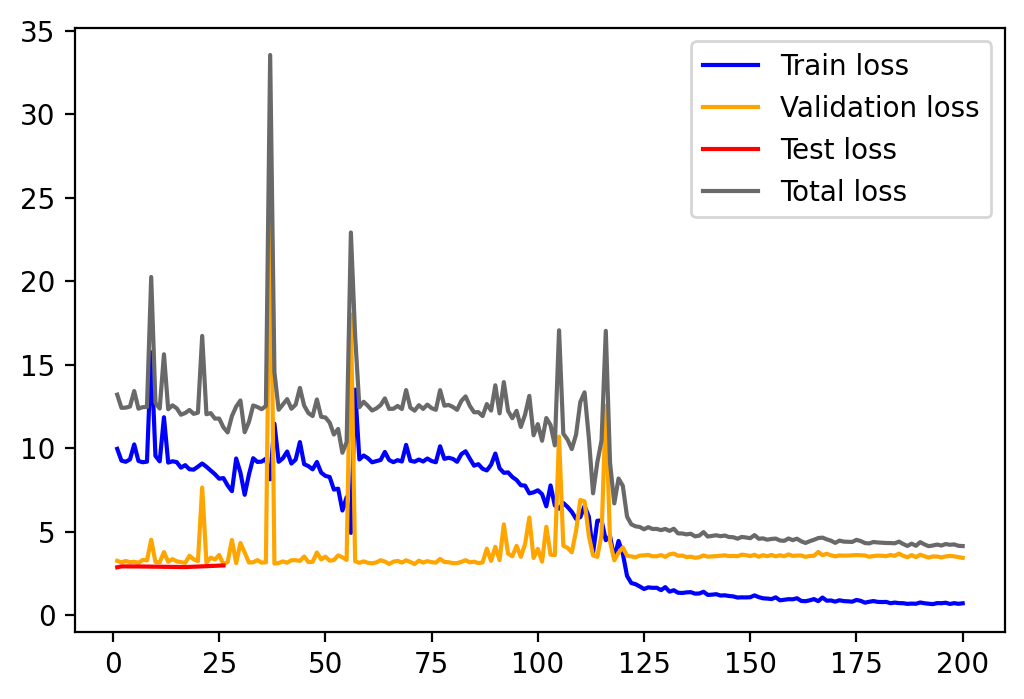

In [26]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [27]:
tsloss = 0
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = best_model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


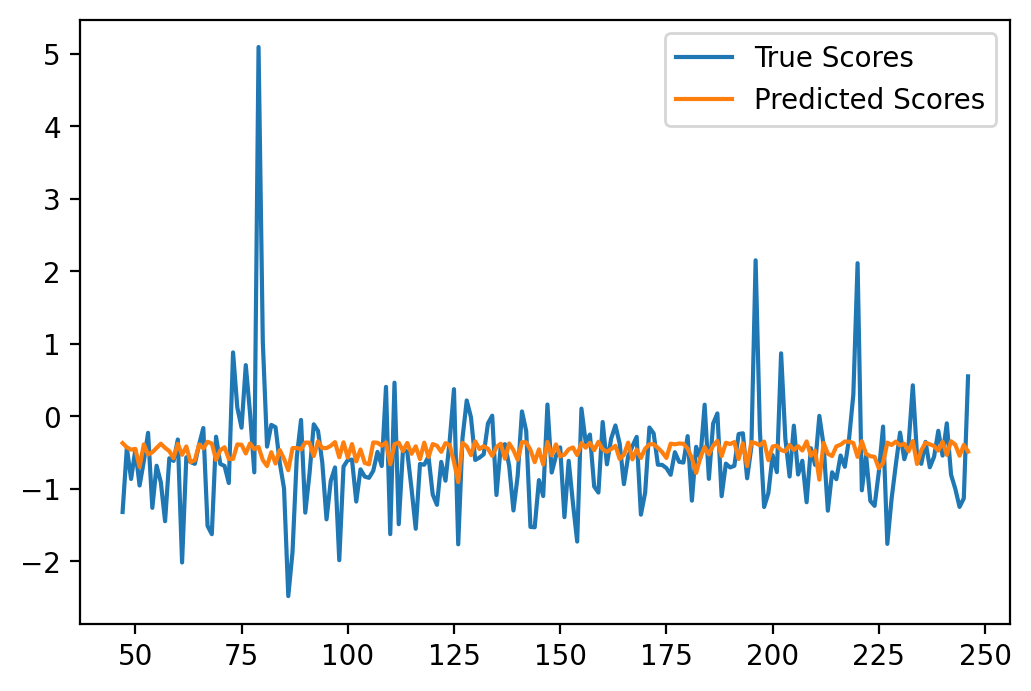

In [28]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.legend()
plt.show()

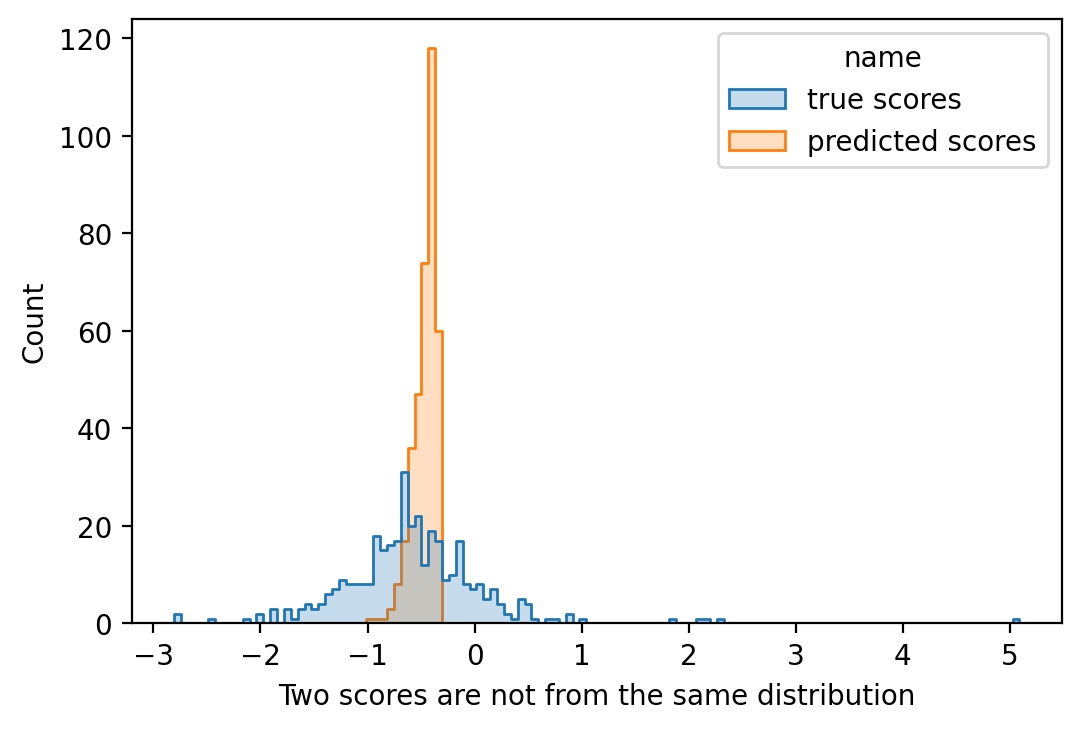

In [29]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'value': true_scores.ravel().tolist(), 'name':'true scores'})
dfy = pd.DataFrame.from_dict({'value': pred_scores.ravel().tolist(), 'name':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='value',hue='name',ax=ax, element='step')

if ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05:
    plt.xlabel('Two scores are not from the same distribution')
else:
    plt.xlabel('Two scores are from the same distribution')

In [32]:
ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05

True